# Sentinel: Credit Card Fraud Detection Training

Train XGBoost model with MLflow experiment tracking via DagsHub.

**Note:** This notebook is optimized for VSCode Colab Extension.

## 1. Setup Environment

In [ ]:
!pip install -q xgboost mlflow dagshub scikit-learn pandas matplotlib seaborn

In [ ]:
import os
import json
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    average_precision_score,
    roc_auc_score,
    f1_score,
    precision_score,
    recall_score
)

import xgboost as xgb
import mlflow
import dagshub

print(f"XGBoost: {xgb.__version__}")
print(f"MLflow: {mlflow.__version__}")
print("Setup complete!")

XGBoost: 3.1.2
MLflow: 3.8.1
Setup complete!


## 2. Download Data from Kaggle

We'll download directly from Kaggle (no Drive needed).

In [ ]:
# Install Kaggle CLI
!pip install -q kaggle

# Create kaggle directory
!mkdir -p ~/.kaggle

In [ ]:
# METHOD 1: Set credentials directly (replace with your actual credentials)
# Get your API token from: https://www.kaggle.com/settings -> API -> Create New Token

KAGGLE_USERNAME = "your_kaggle_username"  # <-- REPLACE THIS
KAGGLE_KEY = "your_kaggle_api_key"        # <-- REPLACE THIS

# Write credentials
kaggle_json = f'{{"username":"{KAGGLE_USERNAME}","key":"{KAGGLE_KEY}"}}'
with open(os.path.expanduser('~/.kaggle/kaggle.json'), 'w') as f:
    f.write(kaggle_json)
!chmod 600 ~/.kaggle/kaggle.json

print("Kaggle credentials configured!")

Kaggle credentials configured!


In [ ]:
# Download dataset
!kaggle datasets download -d mlg-ulb/creditcardfraud -p /content/data --unzip
print("\nDataset downloaded!")
!ls -la /content/data/

Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0
  0% 0.00/66.0M [00:00<?, ?B/s]
100% 66.0M/66.0M [00:00<00:00, 1.70GB/s]

Dataset downloaded!
total 147308
drwxr-xr-x 2 root root      4096 Jan 17 07:28 .
drwxr-xr-x 1 root root      4096 Jan 17 07:28 ..
-rw-r--r-- 1 root root 150828752 Jan 17 07:28 creditcard.csv


## 3. Load & Preprocess Data

In [ ]:
# Load raw data
df = pd.read_csv('/content/data/creditcard.csv')
print(f"Loaded {len(df):,} transactions")
print(f"Fraud cases: {df['Class'].sum():,} ({df['Class'].mean()*100:.4f}%)")

Loaded 284,807 transactions
Fraud cases: 492 (0.1727%)


In [ ]:
# Scale Amount and Time features
scaler = StandardScaler()
df[['Amount', 'Time']] = scaler.fit_transform(df[['Amount', 'Time']])

# Stratified split: 70% train, 15% val, 15% test
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['Class'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['Class'], random_state=42)

print(f"Train: {len(train_df):,} ({train_df['Class'].mean()*100:.4f}% fraud)")
print(f"Val: {len(val_df):,} ({val_df['Class'].mean()*100:.4f}% fraud)")
print(f"Test: {len(test_df):,} ({test_df['Class'].mean()*100:.4f}% fraud)")

Train: 199,364 (0.1725% fraud)
Val: 42,721 (0.1732% fraud)
Test: 42,722 (0.1732% fraud)


In [ ]:
# Prepare features
TARGET = 'Class'
FEATURES = [col for col in df.columns if col != TARGET]

X_train, y_train = train_df[FEATURES], train_df[TARGET]
X_val, y_val = val_df[FEATURES], val_df[TARGET]
X_test, y_test = test_df[FEATURES], test_df[TARGET]

# Calculate class imbalance weight
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"\nScale pos weight: {scale_pos_weight:.1f}")


Scale pos weight: 578.5


## 4. Initialize DagsHub MLflow

In [ ]:
# Connect to DagsHub for experiment tracking
dagshub.init(repo_owner='hammadmunir959', repo_name='my-first-repo', mlflow=True)
mlflow.set_experiment('sentinel-fraud-detection')
print(f"MLflow URI: {mlflow.get_tracking_uri()}")

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=b252ba2f-b57d-4013-ad89-1818708aca27&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=81dc33fd5b312937efdc36250804ef728602d2014ed301d6f0a4d72c58d7ee9f




Accessing as hammadmunir959

Initialized MLflow to track repo "hammadmunir959/my-first-repo"

Repository hammadmunir959/my-first-repo initialized!

2026/01/17 07:29:34 INFO mlflow.tracking.fluent: Experiment with name 'sentinel-fraud-detection' does not exist. Creating a new experiment.


MLflow URI: https://dagshub.com/hammadmunir959/my-first-repo.mlflow


## 5. Train XGBoost Model

In [ ]:
# Hyperparameters
PARAMS = {
    'n_estimators': 200,
    'max_depth': 6,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'scale_pos_weight': scale_pos_weight,
    'random_state': 42,
    'eval_metric': 'aucpr',
    'early_stopping_rounds': 20,
    'n_jobs': -1,
}

In [ ]:
# Helper functions
def compute_metrics(y_true, y_pred, y_prob):
    return {
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1_score': f1_score(y_true, y_pred),
        'roc_auc': roc_auc_score(y_true, y_prob),
        'avg_precision': average_precision_score(y_true, y_prob),
    }

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'])
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.savefig('/content/confusion_matrix.png', dpi=150)
    plt.show()

def plot_feature_importance(model, features, top_n=15):
    imp = model.feature_importances_
    idx = np.argsort(imp)[-top_n:]
    plt.figure(figsize=(8, 6))
    plt.barh(range(len(idx)), imp[idx], color='steelblue')
    plt.yticks(range(len(idx)), [features[i] for i in idx])
    plt.xlabel('Importance')
    plt.title(f'Top {top_n} Features')
    plt.tight_layout()
    plt.savefig('/content/feature_importance.png', dpi=150)
    plt.show()

Training...
[0]	validation_0-aucpr:0.28621
[29]	validation_0-aucpr:0.65967

TEST METRICS
  precision: 0.3464
  recall: 0.8378
  f1_score: 0.4901
  roc_auc: 0.9707
  avg_precision: 0.7428


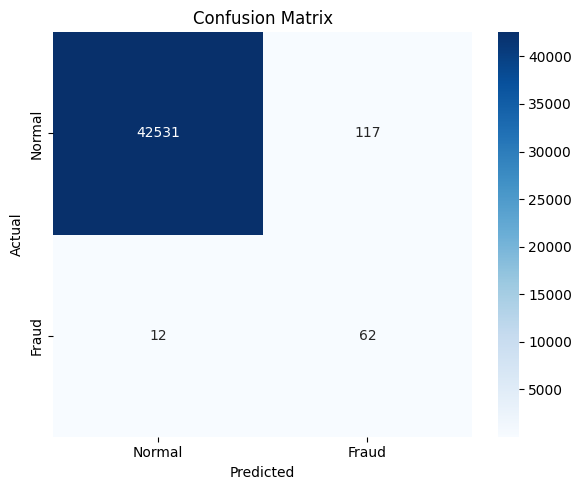

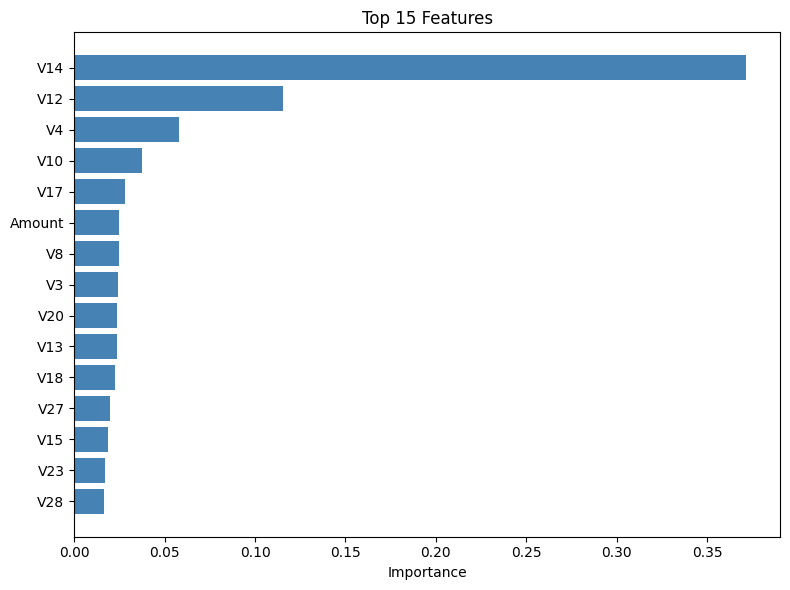

2026/01/17 07:31:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Training complete! Model saved.
🏃 View run xgboost_baseline at: https://dagshub.com/hammadmunir959/my-first-repo.mlflow/#/experiments/0/runs/ed48970dfe5c49a4963744832d6f2d6a
🧪 View experiment at: https://dagshub.com/hammadmunir959/my-first-repo.mlflow/#/experiments/0


In [ ]:
# Train with MLflow logging
with mlflow.start_run(run_name='xgboost_baseline'):
    
    mlflow.log_params(PARAMS)
    
    model = xgb.XGBClassifier(**PARAMS)
    
    print("Training...")
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=50)
    
    # Predictions
    y_test_pred = model.predict(X_test)
    y_test_prob = model.predict_proba(X_test)[:, 1]
    
    # Metrics
    metrics = compute_metrics(y_test, y_test_pred, y_test_prob)
    
    print("\n" + "="*50)
    print("TEST METRICS")
    print("="*50)
    for k, v in metrics.items():
        print(f"  {k}: {v:.4f}")
        mlflow.log_metric(f'test_{k}', v)
    
    # Plots
    plot_confusion_matrix(y_test, y_test_pred)
    plot_feature_importance(model, FEATURES)
    
    # Save & log model
    model.save_model('/content/model.json')
    mlflow.log_artifact('/content/model.json')
    mlflow.log_artifact('/content/confusion_matrix.png')
    mlflow.log_artifact('/content/feature_importance.png')
    mlflow.xgboost.log_model(model, 'model')
    
    print("\nTraining complete! Model saved.")

In [ ]:
# Classification report
print(classification_report(y_test, y_test_pred, target_names=['Normal', 'Fraud']))

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     42648
       Fraud       0.35      0.84      0.49        74

    accuracy                           1.00     42722
   macro avg       0.67      0.92      0.74     42722
weighted avg       1.00      1.00      1.00     42722



## 6. Download Model

Run the cell below to download `model.json` to your local machine.

In [ ]:
# Download model file
from google.colab import files
files.download('/content/model.json')
print("\nPut this file in: ML/Sentinel/models/model.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Put this file in: ML/Sentinel/models/model.json


## Done!

View experiments at: https://dagshub.com/hammadmunir959/my-first-repo/experiments